> A project to analyze hacker news stories using nbdbt

## Analysis

In [1]:
#| echo: false
%reload_ext autoreload
%autoreload 2

In [2]:
#| echo: false
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#| echo: false
%reload_ext nbdbt.dbt_cellmagic

In [4]:
#| echo: false
%dbtconfig -p ../hn_whos_hiring -n notebooks/analysis.ipynb

### Raw HN Source

> This is the raw data for all Hacker News posts

It is sourced from the Google's Big Query Public Datases
and accessible as 
```
bigquery-public-data.hacker_news.full
```

It seems to be updated on a regular basis *(see timestamp of latest post)*.

In [5]:
%%dbt -a raw_sources analyses/raw_hn_source.sql
select *
from {{ source('public_datasets', 'full_stories') }}
order by timestamp desc


In [6]:
df = raw_sources.ref(10); df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"Not sure where you got that from, but that&#x2...",None,seanhunter,NaN,1658567561,2022-07-23 09:12:41+00:00,comment,32201677,32199341,NaN,NaN,None
1,None,None,It&#x27;s a level of &quot;professionalism&quo...,None,foverzar,NaN,1658567556,2022-07-23 09:12:36+00:00,comment,32201676,32201587,NaN,NaN,None
2,None,None,"<a href=""https:&#x2F;&#x2F;github.com&#x2F;cyp...",None,DistrictFun7572,NaN,1658567547,2022-07-23 09:12:27+00:00,comment,32201675,32199828,NaN,NaN,None
3,None,None,"Interesting, why isn&#x27;t the moisture on wa...",None,badpun,NaN,1658567537,2022-07-23 09:12:17+00:00,comment,32201674,32201620,NaN,NaN,None
4,None,None,Why are comments that are critical to the inve...,None,lizardactivist,NaN,1658567512,2022-07-23 09:11:52+00:00,comment,32201673,32200371,NaN,NaN,None


The column names have some descriptions, but might need to be standardized.

In [7]:
df.columns.values

array(['title', 'url', 'text', 'dead', 'by', 'score', 'time', 'timestamp',
       'type', 'id', 'parent', 'descendants', 'ranking', 'deleted'],
      dtype=object)

### Exploratory Data Analysis 
> based on a sample size of 10 latest posts

* Check if time and timestamp contain the same info and one column can be eliminated

In [8]:
from datetime import datetime
import pandas as pd

In [9]:
df['newtimestamp'] = pd.to_datetime(df['time'].astype(float), unit='s',origin='unix', utc=True)

In [10]:
df[df['newtimestamp'] == df['timestamp']].any(axis=None)

True

Looks like they are one and the same.

### EDA Questions

* Check total record count

In [11]:
%%dbt -a tot_rec analyses/count_hn_source.sql
select count(*) as rec_count 
from {{ source('public_datasets', 'full_stories') }}


In [12]:
tot_rec_df = tot_rec.ref()

In [13]:
total_records = tot_rec_df.iloc[0].rec_count

In [14]:
total_records

32201676

* Check if any id, by, time, timestamp, type are null 

In [15]:
%%dbt -a null_field_counts analyses/null_field_counts.sql
with hn_posts
as (
select
     `by` as author,
     * except(`by`)
from {{ source('public_datasets', 'full_stories') }}
)
select 
   'id' as field, 
    count(*) as null_count,
from hn_posts
where id is null
union all
select 
   'author' as field, 
    count(*) as null_count,
from hn_posts
where author is null
union all
select 
   'time' as field, 
    count(*) as null_count,
from hn_posts
where time is null
union all
select 
   'timestamp' as field, 
    count(*) as null_count,
from hn_posts
where timestamp is null
union all
select 
   'type' as field, 
    count(*) as null_count,
from hn_posts
where type is null
union all
select 
   'dead' as field, 
    count(*) as null_count,
from hn_posts
where dead is null
union all
select 'descendants' as field,
    count(*) as null_count
from hn_posts
where descendants is null


In [16]:
null_df = null_field_counts.ref()

In [17]:
null_df['pct'] = null_df['null_count']/total_records

In [18]:
null_df

,field,null_count,pct
0,descendants,28457515,0.883728
1,type,0,0.000000
2,dead,30822943,0.957184
3,id,0,0.000000
4,time,26818,0.000833
5,timestamp,26818,0.000833
6,author,955051,0.029658


| So `type` and `ids` all have values, 
| but there are entries with no `time` or `timestamp` (very small, less than 0.1 percent)
| and there are entries with no `author` (around 3 percent)
| and 96 percent have null values for the `dead` field.

* Check for unique values of `dead`

In [19]:
%%dbt -a dead_type_counts analyses/dead_types_counts.sql
select dead as dead_type, count(*) as dead_count
from {{ source('public_datasets', 'full_stories') }}
group by dead 
order by dead_count desc

In [20]:
dead_types_df = dead_type_counts.ref()
dead_types_df['pct'] = dead_types_df['dead_count']/total_records

In [21]:
dead_types_df

,dead_type,dead_count,pct
0,None,30822943,0.957184
1,True,1378733,0.042816


* Sample dead values

In [22]:
%%dbt -a dead_rows analyses/dead_rows.sql
select * 
from {{ source('public_datasets','full_stories') }}
where dead is not null
limit 10

In [23]:
dead_rows_df = dead_rows.ref()

In [24]:
dead_rows_df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,It&#x27;s true it has a lot of issues.<p>Howev...,True,mixmastamyk,NaN,1451497397,2015-12-30 17:43:17+00:00,comment,10813190,10812214,NaN,NaN,None
1,None,None,"To be clear, if you look through OPs posts, he...",True,fuckmodsahja,NaN,1460954653,2016-04-18 04:44:13+00:00,comment,11517773,11516582,NaN,NaN,None
2,None,None,Kaspersky is currently widely considered to be...,True,cryptoz,NaN,1521230273,2018-03-16 19:57:53+00:00,comment,16603587,16603526,NaN,NaN,None
3,None,None,"&quot;You start out in 1954 by saying, “Nigger...",True,crankylinuxuser,NaN,1521230245,2018-03-16 19:57:25+00:00,comment,16603584,16603507,NaN,NaN,None
4,None,None,Upvote for use of the word &quot;cromulent.&quot;,True,rgejman,NaN,1465358524,2016-06-08 04:02:04+00:00,comment,11859916,11859502,NaN,NaN,None


In [25]:
%%dbt -a not_dead_rows analyses/not_dead_rows.sql
select * 
from {{ source('public_datasets','full_stories') }}
where dead is null
limit 10

In [26]:
not_dead_rows_df = not_dead_rows.ref()

In [27]:
not_dead_rows_df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,Let&#x27;s say the string contains 100 0s and ...,None,dlubarov,NaN,1376497604,2013-08-14 16:26:44+00:00,comment,6212429,6211216,NaN,NaN,None
1,None,None,Eric Schmidt would feel right at home in priso...,None,logn,NaN,1376497595,2013-08-14 16:26:35+00:00,comment,6212428,6210198,NaN,NaN,None
2,None,None,What is the point of submitting a story behind...,None,Quequau,NaN,1420273930,2015-01-03 08:32:10+00:00,comment,8830251,8830214,NaN,NaN,None
3,None,None,But that can be the case for small hatchbacks ...,None,freehunter,NaN,1376497523,2013-08-14 16:25:23+00:00,comment,6212421,6212022,NaN,NaN,None
4,None,None,"Just to be clear, the BSD license did not exis...",None,throwaway2048,NaN,1376497501,2013-08-14 16:25:01+00:00,comment,6212420,6212325,NaN,NaN,None


* Check for unique values of `type`  

In [28]:
%%dbt -a type_counts analyses/types_counts.sql
select type as type, count(*) as type_count
from {{ source('public_datasets', 'full_stories') }}
group by type 
order by type_count desc

In [29]:
types_df = type_counts.ref()
types_df['pct'] = dead_types_df['dead_count']/total_records

In [30]:
types_df

,type,type_count,pct
0,comment,27599990,0.957184
1,story,4570471,0.042816
2,job,15567,NaN
3,pollopt,13668,NaN
4,poll,1980,NaN


## Standardization
> Standardize column names and types so downstream transformations don't have to deal with that

In [31]:
project_dir = '../hn_whos_hiring'
profiles_dir = '~/.dbt'

In [32]:
from fal import FalDbt

In [33]:
faldbt = FalDbt(project_dir,profiles_dir)

In [34]:
source = faldbt.sources[0]

In [35]:
source.schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name
0,bigquery-public-data,hacker_news,full,title,1,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
1,bigquery-public-data,hacker_news,full,url,2,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
2,bigquery-public-data,hacker_news,full,text,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
3,bigquery-public-data,hacker_news,full,dead,4,YES,BOOL,NEVER,None,None,NO,None,NO,NO,NaN,NULL
4,bigquery-public-data,hacker_news,full,by,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
5,bigquery-public-data,hacker_news,full,score,6,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
6,bigquery-public-data,hacker_news,full,time,7,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
7,bigquery-public-data,hacker_news,full,timestamp,8,YES,TIMESTAMP,NEVER,None,None,NO,None,NO,NO,NaN,NULL
8,bigquery-public-data,hacker_news,full,type,9,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
9,bigquery-public-data,hacker_news,full,id,10,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL


In [36]:
%%dbt -a hn_posts models/hn_posts.sql
with stories as (
  select
    * except (`by`),
    `by` as submitter_id,
  from {{ source('public_datasets', 'full_stories') }}
),
latest_stories as (
  select 
     id as post_id, 
     title,
     url,
     submitter_id,
     text as content,
     timestamp as submit_timestamp, -- no need for time since timestamp == time
     ifnull(dead,false) as dead,  
     score as post_score,
     cast(parent as int64) as parent_id,
     type as post_type,
     ranking,
     deleted,
     descendants
   from stories
   order by submit_timestamp desc
)
select *
from latest_stories


In [37]:
model = faldbt.list_models()[0]

In [38]:
model.schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name
0,hn-whos-hiring,00dev,hn_posts,post_id,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
1,hn-whos-hiring,00dev,hn_posts,title,2,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
2,hn-whos-hiring,00dev,hn_posts,url,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
3,hn-whos-hiring,00dev,hn_posts,submitter_id,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
4,hn-whos-hiring,00dev,hn_posts,content,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
5,hn-whos-hiring,00dev,hn_posts,submit_timestamp,6,YES,TIMESTAMP,NEVER,None,None,NO,None,NO,NO,NaN,NULL
6,hn-whos-hiring,00dev,hn_posts,dead,7,YES,BOOL,NEVER,None,None,NO,None,NO,NO,NaN,NULL
7,hn-whos-hiring,00dev,hn_posts,post_score,8,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
8,hn-whos-hiring,00dev,hn_posts,parent_id,9,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
9,hn-whos-hiring,00dev,hn_posts,post_type,10,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL


### Notes on columns 
* post_id = unique identifier
* title = title of the post (can be null if comment?)
* url = link to story
* submitter_id - user id of submitter
* content - body of post
* submit_timestamp - date/time submitted
* dead - ? not sure, but only 4.28 percent are dead, rest are none or false
* score - rating?
* parent_id - link to parent if response to article/comment?
* descendants - ? count of descendants?
* ranking - ?
* deleted - ?
* post_type = 'story','comment', 'job','pollopt', 'poll'

In [39]:
# %cd ../hn_whos_hiring
# !dbt run -s models/hn_posts.sql
# %cd ../notebooks

In [40]:
model = faldbt.models[0]; model.name

'hn_posts'

In [41]:
model.schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name
0,hn-whos-hiring,00dev,hn_posts,post_id,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
1,hn-whos-hiring,00dev,hn_posts,title,2,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
2,hn-whos-hiring,00dev,hn_posts,url,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
3,hn-whos-hiring,00dev,hn_posts,submitter_id,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
4,hn-whos-hiring,00dev,hn_posts,content,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL
5,hn-whos-hiring,00dev,hn_posts,submit_timestamp,6,YES,TIMESTAMP,NEVER,None,None,NO,None,NO,NO,NaN,NULL
6,hn-whos-hiring,00dev,hn_posts,dead,7,YES,BOOL,NEVER,None,None,NO,None,NO,NO,NaN,NULL
7,hn-whos-hiring,00dev,hn_posts,post_score,8,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
8,hn-whos-hiring,00dev,hn_posts,parent_id,9,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL
9,hn-whos-hiring,00dev,hn_posts,post_type,10,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL


### More questions
* meaning of dead
* what is ranking
* what is deleted
* ~~is parent_id the link for a graph of article/comments/responses to comment?~~
* what is descendants

### Related to who's hiring

* how to filter who's hiring posts
* create a pipeline for text analysis

### Parent ID questions

* Do all parent_ids point to valid post_ids?

In [42]:
%%dbt  analyses/missing_parent_post_count.sql
with child as (
    select post_id as child_id,
           parent_id,
    from {{ ref('hn_posts') }}
    where parent_id is not null
),
parent as (
    select post_id as parent_id,
    from  {{ ref('hn_posts') }}
),
parent_child as (
    select c.child_id,
           p.parent_id,
    from child c
    left join parent p
    on c.parent_id = p.parent_id
)
select count(*) as unmatched_count
from parent_child 
where parent_id is null

,unmatched_count
0,0


Looks like the answer is yes.

### What are descendants
 

In [43]:
%%dbt analyses/sample_rows_with_descendants.sql
select *
from {{ ref('hn_posts') }}
where descendants is not null
limit 10

,post_id,title,url,submitter_id,content,submit_timestamp,dead,post_score,parent_id,post_type,ranking,deleted,descendants
0,32201648,I Got Scammed on an EVGA Nvidia GeForce RTX 3090,https://www.servethehome.com/how-i-got-scammed...,giuliomagnifico,None,2022-07-23 09:06:46+00:00,False,1,NaN,story,NaN,None,0
1,32201643,Vodafone to introduce persistent user tracking,https://blog.simpleanalytics.com/vodafone-deut...,pumkesjaan,None,2022-07-23 09:05:20+00:00,False,3,NaN,story,NaN,None,0
2,32201629,"Four Tet on His 155-Hour Spotify Playlist, the...",https://pitchfork.com/thepitch/four-tet-on-his...,dymv,None,2022-07-23 09:01:20+00:00,False,1,NaN,story,NaN,None,1
3,32201621,Fuck Nebraska,https://jbond14.github.io//world/2022/03/05/th...,funthree,None,2022-07-23 09:00:01+00:00,False,3,NaN,story,NaN,None,0
4,32201615,"Ask HN: Dear Cisco, free licenses for home labs?",None,logotype,If anyone from Cisco reads this:\nWhy not offe...,2022-07-23 08:59:11+00:00,False,1,NaN,story,NaN,None,0
5,32201573,How AI is reinventing what computers are,https://www.technologyreview.com/2021/10/22/10...,rbanffy,None,2022-07-23 08:50:53+00:00,False,2,NaN,story,NaN,None,0
6,32201558,Ask HN: How did you increase your conference s...,None,firstSpeaker,None,2022-07-23 08:49:04+00:00,False,1,NaN,story,NaN,None,0
7,32201548,Galactic-Scale Energy – Do the Math (2011),https://dothemath.ucsd.edu/2011/07/galactic-sc...,grey_earthling,None,2022-07-23 08:46:54+00:00,False,1,NaN,story,NaN,None,0
8,32201535,Ukraine’s Open-Source War,https://www.ft.com/content/297d3300-1a65-4793-...,samizdis,None,2022-07-23 08:43:01+00:00,False,2,NaN,story,NaN,None,2
9,32201513,More AI debate between me and Steven Pinker,https://scottaaronson.blog/?p=6593,nsoonhui,None,2022-07-23 08:38:58+00:00,False,1,NaN,story,NaN,None,0


In [44]:
%%dbt analyses/descendants_is_count_of_children.sql
select parent_id, count(*) as child_count
from {{ ref('hn_posts') }}
where parent_id in (32201573,32201535,32201615, 32201513)
group by parent_id

,parent_id,child_count
0,32201535,1


In [45]:
%%dbt analyses/descendants_is_count_of_children.sql
select *
from {{ ref('hn_posts') }}
where parent_id in (32201573,32201535,32201615, 32201513)

,post_id,title,url,submitter_id,content,submit_timestamp,dead,post_score,parent_id,post_type,ranking,deleted,descendants
0,32201545,None,None,politelemon,Behind a paywall,2022-07-23 08:46:12+00:00,False,NaN,32201535,comment,NaN,None,NaN


* descendants don't always reflect count of comments

In [46]:
%%dbt analyses/descendants_range_of_values.sql
select max(descendants) as max_descendants,
       min(descendants) as min_descendants
from {{ ref('hn_posts') }}
where descendants is not null

,max_descendants,min_descendants
0,4576,-1


In [47]:
%%dbt -a descendants_distrib analyses/descendants_distribution.sql
select descendants, count(*) as instances
from {{ ref('hn_posts') }}
where descendants is not null
group by descendants
order by instances desc

In [48]:
descendants_distrib_df = descendants_distrib.ref()

In [49]:
%%dbt analyses/descendants_is_count_of_children.sql
select parent_id, count(*) as child_count
from {{ ref('hn_posts') }}
where parent_id in (32201573,32201535,32201615, 32201513)
group by parent_id

,parent_id,child_count
0,32201535,1


In [50]:
import numpy as np

In [51]:
descendants_distrib_df['log_inst'] = np.log(descendants_distrib_df.instances)

In [52]:
descendants_distrib_df

,descendants,instances,log_inst
0,0,2430889,14.703768
1,1,344379,12.749498
2,-1,271201,12.510616
3,2,123541,11.724328
4,3,66816,11.109698
...,...,...,...
995,1432,1,0.000000
996,779,1,0.000000
997,1083,1,0.000000
998,850,1,0.000000


array([[<AxesSubplot:title={'center':'instances'}>]], dtype=object)

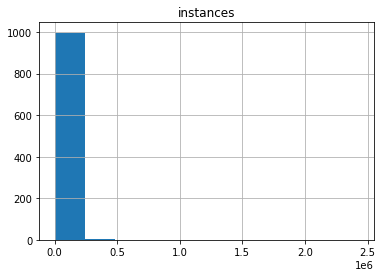

In [53]:
descendants_distrib_df.hist(column='instances')

array([[<AxesSubplot:title={'center':'log_inst'}>]], dtype=object)

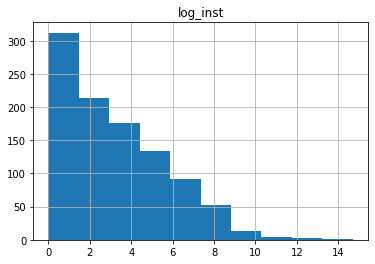

In [54]:
descendants_distrib_df.hist(column='log_inst',)

* Nothing stands out in the distribution of descendants values

### Comments

In [55]:
%%dbt analyses/comments_without_parents.sql
select count(*) as top_level_comment_count
from {{ ref('hn_posts') }}
where post_type = 'comment' 
  and parent_id is null

,top_level_comment_count
0,0


* all comments have parents